## Doubly Robust Average Treatment Effects Estimation with Multiple Treatments

### Introduction and Problem Statement

Suppose we want to evaluate the impact of a government sponsored job training program on individual earnings. Training can take multiple forms - classroom training, on the job vocational training, or a mix of the two. A randomized trial is conducted wherein applicants were assigned to either a treatment arm where they received some form of training under the program, or a control arm where they didn't. Therefore, there were four total "arms" in the experiment. As a data analyst, our objective is to use the data from this experiment to analyze if training was actually helpful. 

The Job Training Partnership Act (JTPA) Study from the late 1980's is a widely cited experiment which did exactly this. There is one major caveat - applicants to the program were not randomly assigned to one of four treatment arms. Rather, an applicant who was deemed eligible for help under the program was first evaluated by a case worker who determined the best training strategy for them - one of classroom, on the job (OJT) or mixed training. After this decision was made for all eligible applicants, the pool of agents was randomly split into a treatment arm and control arm with probabilities 2/3 and 1/3, respectively. Therefore, even though assignment to *some* form of training was random, assignment to any *particular* training regime was not. 

The objective of this notebook is to describe a strategy to estimate the possible gains from each of the three forms of training. This will be done using the potential outcomes framework - namely, if $Y(d)$ denotes an individual's earnings after receiving treatment $d$ where $d\in \{\text{classroom}, \text{OJT}, \text{mixed}\}$, then we are interested in the average difference in earnings, relative to no training (represented as $d= 0$) i.e.
\begin{align}
\mathbb{E}[Y(d) - Y(0)], \hspace{3mm}\text{for }d\in \{\text{classroom}, \text{OTJ}, \text{mixed}\},
\end{align}
where $Y(0)$ represents the earnings under no treatment. The difference above is the average treatment effect for treatment $d$ or $ATE(d)$ and is considered a causal object i.e. if $ATE(d)$ is negative, we may (very roughly) say that the on average lower than baseline earnings of people who were given training $d$ was *caused* by training $d$. 

Under appropriate assumptions which are not covered here, if we are presented with data from a randomized experiment $(Y_i, X_i, D_i)$ for $i=1, ...,n$ where $Y_i$ denotes earnnings of agent $i$, $X_i$ is a vector of characteristics prior to assignment to a treatment arm, and $D_i$ denotes their assigned treatment arm, then the following is a doubly robust estimator for $\mathbb{E}[Y(d)]$:
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{Y_i - \mu_d(X_i)}{p_d(X_i)}\cdot \mathrm{1}\{D_i = d\} + \mu_d(X_i),
\end{align}
where the objects $\mu_d, p_d$ represent the following conditional mean functions:
\begin{align}
\mu_d(x) & = \mathbb{E}[Y_i(d) \mid X_i = x]\\
p_d(x) & = \mathbb{P}(D_i = d \mid X_i = x).
\end{align}
In finite samples, we don't know the functions $\mu_d, p_d$ and must therefore estimate them as $\hat{\mu}_d, \hat{p}_d$. The estimator above is called doubly robust because with a large enough dataset, it approximately equals $\mathbb{E}[Y(d)]$ if either $\mu_d$ or $p_d$ are poorly estimated. 


Using a doubly robust specification has two main advantages. First of all, it can be shown that if we have data for many participants (i.e. $n$ is large), the doubly robust estimator shown above will lead to an extremely precise estimate of the average treatment effect of training $d$, $ATE(d)$. Indeed, out of many sensible ways to measure the causal impact of training, the doubly robust estimator will offer the most precise estimate, in the sense of having the lowest possible variance (or spread). While interesting, low variance is not the main objective of the exercise described here. Rather, it is the second advantage of doubly robust estimators which is more important.

Recall that in order to actually use the doubly robust estimator, we first need to form estimates $\hat{\mu}_d, \hat{p}_d$. Modern machine learning methods offer high quality estimates of precisely this form. In practice though, it was noticed that simply estimating $\hat{\mu}_d$ using a modern ML method (LASSO, say) and estimating $ATE(d)$ naively as,
\begin{align}
\frac{1}{n}\sum_{i=1}^n\hat{\mu}_d(X_i) - \hat{\mu}_0(X_i),
\end{align}
would perform poorly and suffer from high variance and bias regardless of ML best practices, unless data sets were extremely large. The doubly robust estimator, combined with a form of cross fitted regression estimation delivers a superior estimate of $ATE(d)$. The rest of this notebook will now describe the exact steps needed to compute reliable estimates of $ATE(d)$, and then implement these steps.

### Estimation Strategy

Recall that we have a dataset given by $(Y_i, X_i, D_i)_{i=1}^n$. For any $d$, we calculate an estimate for $\mathbb{E}[Y(d)]$ using the following steps:

1. Randomly partition the observations ${1,2,...,n}$ into folds $(I_l)_{l=1}^L$ of approximately equal size. Here $I_l$ is a list of indices for obervations in fold $l$. Let $I_l^c$ denote all observations not in fold $l$.
2. For each fold $l$, esimate $\hat{\mu}_d^l, \hat{p}_d^l$ using observations in $I_l^c$. Exactly how these are estimated is discussed below.
3. After estimation is done for all folds, define the following estimate:  
\begin{align}
\hat{\mathbb{E}}[Y_i(d)] = \frac{1}{n}\sum_{l=i}^L \sum_{i\in I_l}\frac{Y_i - \hat{\mu}^l_d(X_i)}{\hat{p}^l_d(X_i)}\cdot \mathrm{1}\{D_i = d\} + \hat{\mu}^l_d(X_i)
\end{align}
4. Define the estimated casual impact of training $d$ as:
\begin{align}
\hat{ATE}(d) = \hat{\mathbb{E}}[Y_i(d)] - \hat{\mathbb{E}}[Y_i(0)].
\end{align}

The above steps describe the cross-fitting process needed to reliably estimate our causal impacts of interest. The intermediate estimates $\hat{\mu}^l_d$ and $\hat{p}^l_d$ for each of the folds will be derived using appropriate machine learning or high dimensional methods. The primary difference between these two functions is that $\hat{\mu}^l_d$ should be the output of a regression algorithm (e.g. LASSO, random forests), while $\hat{p}_d^l$ should be the output of a multi-arm classification algorithm (e.g. multinomial penalized logistic regression). We can now begin implementing the estimation strategy outlined here. 

### Implementation

In [2]:
#Load in necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#Include modeling tools.
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, accuracy_score

##### Loading Dataset and Pre-processing

In [3]:
jtpa = pd.read_csv('jtpa_reasons_outcome.csv', index_col='recid')
vars_to_keep = ['assignmt', 'sex', 'class_tr', 'ojt_jsa', 'oth_serv', 'age' , 'earnings', 'prevearn', 'married', 'pbhous', 'wkless13', 'bfeduca']
jtpa_keep = jtpa[vars_to_keep]

#Construct recommended training variable
rec_training = ["" for i in range(jtpa_keep.shape[0])]
for i in range(jtpa_keep.shape[0]):
    if jtpa_keep.class_tr.iloc[i] ==1:
        rec_training[i] = 'classroom'
    elif jtpa_keep.ojt_jsa.iloc[i] ==1:
        rec_training[i] = 'ojt'
    elif jtpa_keep.oth_serv.iloc[i]==1:
        rec_training[i] = 'other' 

jtpa_keep.insert(jtpa_keep.shape[1], 'recommended_training', rec_training, True)
#Drop original variables
jtpa_keep = jtpa_keep.drop(['class_tr', 'ojt_jsa', 'oth_serv'], axis = 1)

#Shape of dataset
jtpa_keep.shape

(11204, 10)

In [47]:
jtpa_keep.describe().round(2)

,assignmt,sex,age,earnings,prevearn,married,pbhous,wkless13,bfeduca
count,11204.00,11204.00,11204.00,11204.00,11204.00,11204.00,11204.00,11204.00,11204.00
mean,0.67,0.46,33.14,15815.29,3202.31,0.28,0.09,0.46,13.09
std,0.47,0.50,9.64,16767.05,3901.45,0.43,0.28,0.47,11.61
min,0.00,0.00,22.00,0.00,0.00,0.00,0.00,0.00,7.00
25%,0.00,0.00,26.00,1929.75,98.00,0.00,0.00,0.00,11.00
50%,1.00,0.00,31.00,11010.00,2444.66,0.00,0.00,0.41,12.00
75%,1.00,1.00,38.00,24798.25,4103.91,1.00,0.00,1.00,12.00
max,1.00,1.00,78.00,155760.00,63000.00,1.00,1.00,1.00,99.00


There are some missing values and data issues. For example, the column `bfeduca` records an applicants education (in years) at the time they applied to the JTPA for help. The value 99 corresponds to a missing value. An applicant's education level is typically highly correlated with their ability to benefit from training - so a missing value severely reduces the informativeness of such an observation and may be removed, as long as there aren't too many missing values. 

It is also important to check for clear errors - for example, if the binary variables in the dataset have entries which are neither `0` not `1`. The following code block replaces missing values and data errors in the variables with `NaN`. Observations with any missing values are then dropped. 

In [4]:
#Missing values in applicant education levels.
jtpa_keep.bfeduca.replace(99, np.nan, inplace=True)

#Replace non-0,1 values in binary variables with NaN
binary_vars = [e for e in list(jtpa_keep.columns) if e not in ['age', 'earnings', 'prevearn', 'bfeduca', 'recommended_training']]
for v in binary_vars:
    #No. of errors
    errors = ~((jtpa_keep[v]==0)|(jtpa_keep[v]==1))
    if np.sum(errors)>=1:
        jtpa_keep.loc[errors, v] = np.nan

print('No. of missing values generated: ')
print(jtpa_keep.isnull().sum())

#Drop observations with missing data
jtpa_keep = jtpa_keep.dropna(axis = 0) 
#How many observations were lost? Originally, we had 11204 obs. Now it is 11008.
jtpa_keep.shape[0]

No. of missing values generated: 
assignmt                   0
sex                        0
age                        0
earnings                   0
prevearn                   0
married                  764
pbhous                   229
wkless13                1178
bfeduca                  196
recommended_training       0
dtype: int64


9191

In [5]:
#Change some binary variables to categorical for better visualization
jtpa_keep['sex'].replace([0,1],['Female', 'Male'], inplace = True)
jtpa_keep['assignmt'].replace([0,1],['Control', 'Treatment'], inplace = True)
jtpa_keep['pbhous'].replace([0,1],['No', 'Yes'], inplace = True)
jtpa_keep['married'].replace([0,1],['Not married', 'Married'], inplace = True)
jtpa_keep['wkless13'].replace([0,1],['Did not work', 'Worked'], inplace = True)
#jtpa_keep['training'].replace([0,1],['No training', 'Trained'], inplace = True)


#Transfrom post-training phase earnings and earnings prior to assignment to be in thousands ('000s).
jtpa_keep['earnings']  = jtpa['earnings']/1000
jtpa_keep['prevearn']  = jtpa['prevearn']/1000

jtpa_keep.describe().round(2)

,age,earnings,prevearn,bfeduca
count,9191.00,9191.00,9191.00,9191.00
mean,33.01,16.47,3.32,11.63
std,9.63,17.19,4.10,1.85
min,22.00,0.00,0.00,7.00
25%,26.00,2.23,0.04,11.00
50%,31.00,11.64,2.40,12.00
75%,38.00,25.72,4.80,12.00
max,78.00,155.76,63.00,18.00


In [6]:
jtpa_keep.describe(include = ['object'])

,assignmt,sex,married,pbhous,wkless13,recommended_training
count,9191,9191,9191,9191,9191,9191
unique,2,2,2,2,2,3
top,Treatment,Female,Not married,No,Did not work,ojt
freq,6124,4842,6561,8413,5057,4066


Finally, remove some outliers in data for earnings of an applicant in the year prior to treatment assignment (`prevearn`).

In [7]:
jtpa_keep = jtpa_keep[(np.abs(stats.zscore(jtpa_keep.prevearn))<3)]

##### Feature Engineering

The primary continuously distributed covariate/feature is `prevearn`. In what follows, we will first augment the set of explanatory variables with raised powers of `prevearn`. We till then augment with interactions with the binary variables in the dataset.

In [8]:
jtpa_features_augmented = jtpa_keep.drop(['earnings', 'recommended_training', 'assignmt'], axis = 1).copy()

#Create Dummies for the recommended training
jtpa_features_augmented = pd.get_dummies(jtpa_features_augmented)

#Add powers of 'prevearn'
for n in range(2, 4):
    jtpa_features_augmented['prevearn_{}'.format(n)] = jtpa_keep.prevearn**n

#Now add interactions upto user specified order
poly_terms = PolynomialFeatures(degree = (2,4), include_bias=False)
poly_terms.fit(jtpa_features_augmented)
jtpa_features_polyterms_colnames =poly_terms.get_feature_names_out(jtpa_features_augmented.columns)
jtpa_features_polyterms = pd.DataFrame(poly_terms.fit_transform(jtpa_features_augmented), index = jtpa_keep.index)
jtpa_features_polyterms.columns = jtpa_features_polyterms_colnames

#Drop duplicated columns. Higher order interactions of binary variables will equal lower order interaction terms.
jtpa_features_polyterms = jtpa_features_polyterms.loc[:, ~jtpa_features_polyterms.T.duplicated(keep = 'first')]

#How many unique features do we end up with?
print('original no. of features: ', jtpa_features_augmented.shape[1])
print('Interactions and higher order terms: ', jtpa_features_polyterms.shape[1])


original no. of features:  13
Interactions and higher order terms:  1228


In [9]:
jtpa_features_augmented.head(1)

,age,prevearn,bfeduca,sex_Female,sex_Male,married_Married,married_Not married,pbhous_No,pbhous_Yes,wkless13_Did not work,wkless13_Worked,prevearn_2,prevearn_3
recid,,,,,,,,,,,,,
300001,46,0.0,12.0,1,0,0,1,1,0,0,1,0.0,0.0


In [10]:
jtpa_features_polyterms.head(1)

,age^2,age prevearn,age bfeduca,age sex_Female,age sex_Male,age married_Married,age married_Not married,age pbhous_No,age pbhous_Yes,age wkless13_Did not work,age wkless13_Worked,age prevearn_2,age prevearn_3,prevearn^2,prevearn bfeduca,prevearn sex_Female,prevearn sex_Male,prevearn married_Married,prevearn married_Not married,prevearn pbhous_No,prevearn pbhous_Yes,prevearn wkless13_Did not work,prevearn wkless13_Worked,prevearn prevearn_2,prevearn prevearn_3,bfeduca^2,bfeduca sex_Female,bfeduca sex_Male,bfeduca married_Married,bfeduca married_Not married,bfeduca pbhous_No,bfeduca pbhous_Yes,bfeduca wkless13_Did not work,bfeduca wkless13_Worked,bfeduca prevearn_2,bfeduca prevearn_3,sex_Female^2,sex_Female sex_Male,sex_Female married_Married,sex_Female married_Not married,sex_Female pbhous_No,sex_Female pbhous_Yes,sex_Female wkless13_Did not work,sex_Female wkless13_Worked,sex_Female prevearn_2,sex_Female prevearn_3,sex_Male^2,sex_Male married_Married,sex_Male married_Not married,sex_Male pbhous_No,...,married_Not married pbhous_Yes wkless13_Did not work prevearn_2,married_Not married pbhous_Yes wkless13_Did not work prevearn_3,married_Not married pbhous_Yes wkless13_Worked prevearn_2,married_Not married pbhous_Yes wkless13_Worked prevearn_3,married_Not married pbhous_Yes prevearn_2^2,married_Not married pbhous_Yes prevearn_2 prevearn_3,married_Not married pbhous_Yes prevearn_3^2,married_Not married wkless13_Did not work prevearn_2^2,married_Not married wkless13_Did not work prevearn_2 prevearn_3,married_Not married wkless13_Did not work prevearn_3^2,married_Not married wkless13_Worked prevearn_2^2,married_Not married wkless13_Worked prevearn_2 prevearn_3,married_Not married wkless13_Worked prevearn_3^2,married_Not married prevearn_2^3,married_Not married prevearn_2^2 prevearn_3,married_Not married prevearn_2 prevearn_3^2,married_Not married prevearn_3^3,pbhous_No wkless13_Did not work prevearn_2^2,pbhous_No wkless13_Did not work prevearn_2 prevearn_3,pbhous_No wkless13_Did not work prevearn_3^2,pbhous_No wkless13_Worked prevearn_2^2,pbhous_No wkless13_Worked prevearn_2 prevearn_3,pbhous_No wkless13_Worked prevearn_3^2,pbhous_No prevearn_2^3,pbhous_No prevearn_2^2 prevearn_3,pbhous_No prevearn_2 prevearn_3^2,pbhous_No prevearn_3^3,pbhous_Yes wkless13_Did not work prevearn_2^2,pbhous_Yes wkless13_Did not work prevearn_2 prevearn_3,pbhous_Yes wkless13_Did not work prevearn_3^2,pbhous_Yes wkless13_Worked prevearn_2^2,pbhous_Yes wkless13_Worked prevearn_2 prevearn_3,pbhous_Yes wkless13_Worked prevearn_3^2,pbhous_Yes prevearn_2^3,pbhous_Yes prevearn_2^2 prevearn_3,pbhous_Yes prevearn_2 prevearn_3^2,pbhous_Yes prevearn_3^3,wkless13_Did not work prevearn_2^3,wkless13_Did not work prevearn_2^2 prevearn_3,wkless13_Did not work prevearn_2 prevearn_3^2,wkless13_Did not work prevearn_3^3,wkless13_Worked prevearn_2^3,wkless13_Worked prevearn_2^2 prevearn_3,wkless13_Worked prevearn_2 prevearn_3^2,wkless13_Worked prevearn_3^3,prevearn_2^4,prevearn_2^3 prevearn_3,prevearn_2^2 prevearn_3^2,prevearn_2 prevearn_3^3,prevearn_3^4
recid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300001,2116.0,0.0,552.0,46.0,0.0,0.0,46.0,46.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,12.0,0.0,0.0,12.0,12.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Full set of features
jtpa_features = jtpa_features_augmented.merge(jtpa_features_polyterms, on = 'recid')
jtpa_features.shape

(9041, 1241)

##### Some Descriptive Statistics

Before continuing, it is useful to see how agents were assigned to the treatment/control arms. The following table shows how applicants were assigned to treatment and control, by an applicant's sex (`= 1` if Male). The variable `assignmt` equals `1` if the applicant was assigned to the treatment arm, and the variable `recommended_training` displays the recommended training (recall that this decision was made by a case worker *prior to assignment*).  

In [8]:
assigned_table = pd.crosstab(index = jtpa_keep.assignmt, 
                            columns = [jtpa_keep.recommended_training, jtpa_keep.sex] , margins = True)
assigned_table

recommended_training    OJT       classroom       other         All
sex                  Female  Male    Female Male Female  Male      
assignmt                                                           
Control                 630   720       634  278    339   416  3017
Treatment              1198  1447      1248  607    765   759  6024
All                    1828  2167      1882  885   1104  1175  9041

The following figure shows the distribution of income prior to assignment, split by an applicant's sex.

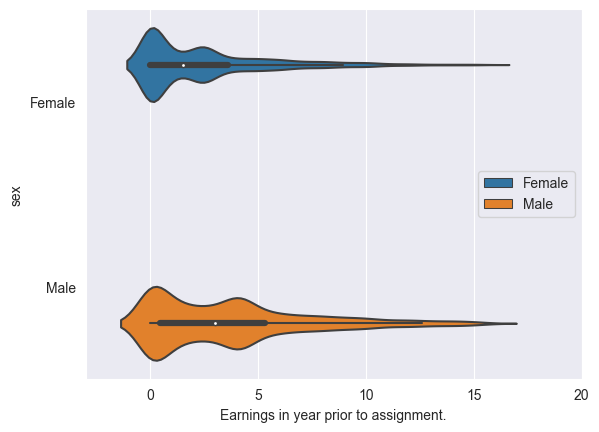

In [9]:
sns.violinplot(data = jtpa_keep, 
                x = 'prevearn',
                y = 'sex',
                hue = 'sex')
plt.legend(loc='center right')
plt.xlim(-3, 20)
plt.xlabel('Earnings in year prior to assignment.')
plt.show()

#### Estimating Conditional Means

We first estimate the conditional mean functions $\hat{\mu}_d$ for all values of $d$ (including $d=0$). Estimated values $\hat{\mu}_d$ are saved and exported.

##### Cross Fitting Procedure

The following functions implements the cross fitting routine described above. It requires a dictionary of model pipelines - each element corresponding to a particular regression algorithm - and a dictionary of model hyperparameters. The number of data folds must be set as well. The function then fits the best model out of the candidates considered and outputs predicted values for a given set of data. 

In [12]:
def cross_fit_regression(X, y, obs, model_pipelines, model_hyperparameters, folds =2, r_state = 123, show_progress = False):

    pred = np.zeros((len(y), 1))
    #Initialize data splitting:
    kf = KFold(n_splits = folds)
    #For each fold, fit model and return predicted outcome.
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        feature_data, outcome_data = X.iloc[train_index, :][obs.iloc[train_index]], y.iloc[train_index][obs.iloc[train_index]]
        (X_train, X_test, y_train, y_test) = train_test_split(feature_data, outcome_data, test_size=0.2, random_state = r_state)
        fitted_models = {}
        for name, pipeline in model_pipelines.items():
            model = GridSearchCV(pipeline, model_hyperparameters[name], cv = 2, n_jobs = -1)
            model.fit(X_train, y_train)
            fitted_models[name] = model
            if show_progress:
                print('For fold {}, model {} fitted.'.format(i, name))

        #Choose the best model
        #First initialize sample prediction error
        pred_error = {}
        #Calculate prediction error for each model.
        for name, model in fitted_models.items():
            model_pred = model.predict(X_test)
            model_error = r2_score(y_test, model_pred)
            pred_error[name] = model_error
        #Predicted values from best model
        best_model = np.array(list(pred_error.keys()))[list(pred_error.values()) == max(list(pred_error.values()))][0]
        pred[test_index, :] = fitted_models[best_model].predict(X.iloc[test_index, :]).reshape(-1,1) 
        if show_progress:
            print('Predicted values for fold {} derived.'.format(i))
    return pred

In [13]:
#Make pipelines for regression estimation
pipelines_regression = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet' : make_pipeline(StandardScaler(), ElasticNet(random_state = 123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))
}

In [14]:
# Lasso hyperparameters
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}

# Ridge hyperparameters
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}
# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}
#Random Forest Regressor hyperparameters
rfr_hyperparameters = {'randomforestregressor__n_estimators': [100, 200],
                    'randomforestregressor__max_features': ['sqrt', 0.33]
                    }
#Gradient Boosted Regressor hyperparameters
gbr_hyperparameters = {'gradientboostingregressor__n_estimators': [100, 200],
                        'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
                        'gradientboostingregressor__max_depth': [1, 3, 5]}
                        
# Create hyperparameters dictionary
hyperparameters_regression = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rfr_hyperparameters
}


The following code block estimates the conditional mean functions and exports the estimated.

In [77]:
jtpa_with_mean_pred = jtpa_keep.copy()
for d in ['classroom', 'ojt', 'other', 'control']:
    if d == 'control':
        obs = (jtpa_keep.assignmt=='Control')
        print('Treatment arm: {}, '.format(d), 'obs.: ', obs.sum())
    else:
        obs = (jtpa_keep.assignmt=='Treatment')&(jtpa_keep.recommended_training==d)
        print('Treatment arm: {}, '.format(d), 'obs.: ', obs.sum())

    predicted_outcome = cross_fit_regression(X = jtpa_features, y= jtpa_keep.earnings,
                                            obs = obs, 
                                            model_pipelines = pipelines_regression, 
                                            model_hyperparameters = hyperparameters_regression,
                                            folds= 5)
    results = pd.DataFrame(predicted_outcome, columns = ['pred_earnings_{}'.format(d)], index = jtpa_keep.index)

    #Add estimated outcome to dataset.
    jtpa_with_mean_pred = jtpa_with_mean_pred.join(results, on = 'recid')
    results.to_csv(str('pred_earnings_{}.csv'.format(d)))
    print('Estimation completed for treatment arm: {}.'.format(d))

#Export the dataset with predicted mean values.
jtpa_with_mean_pred.to_csv('data_with_pred_outcomes.csv')

Treatment arm: classroom,  obs.:  1855
Estimation completed for treatment arm: classroom.
Treatment arm: OJT,  obs.:  2645
Estimation completed for treatment arm: OJT.
Treatment arm: other,  obs.:  1524
Estimation completed for treatment arm: other.
Treatment arm: control,  obs.:  3017
Estimation completed for treatment arm: control.


#### Estimating Conditional Probabilities

The conditional probability functions $\hat{p}_d$ must satisfy the propoerties of a probability distribution function. Namely, 
\begin{align}
& 0\leq \hat{p}_d(x)\leq 1 \hspace{3mm}\text{for all values $x$},\\
& \sum_{d}\hat{p}_d(x) = 1\hspace{3mm}\text{for all values $x$.}
\end{align}

##### Cross Fitting Procedure for Conditional Probability Estimation

The following function implements the cross fitted estimation routine, but for when conditional probabilities must be estimated. It is very similar to `cross_fit_regression()`.

In [15]:
def cross_fit_classification(X, y, model_pipelines, model_hyperparameters, folds =2, r_state = 123, show_progress = False):

    pred = np.zeros((len(y), 4))
    #Initialize data splitting:
    kf = KFold(n_splits = folds)
    #For each fold, fit model and return predicted outcome.
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        feature_data, outcome_data = X.iloc[train_index, :], y.iloc[train_index]
        (X_train, X_test, y_train, y_test) = train_test_split(feature_data, outcome_data, test_size=0.2, random_state = r_state)
        fitted_models = {}
        for name, pipeline in model_pipelines.items():
            model = GridSearchCV(pipeline, model_hyperparameters[name], cv = 2, n_jobs = -1)
            model.fit(X_train, y_train)
            fitted_models[name] = model

        #Choose the best model
        #First initialize sample prediction error
        pred_error = {}
        #Calculate prediction error for each model.
        for name, model in fitted_models.items():
            model_pred = model.predict(X_test)
            model_error = accuracy_score(y_test, model_pred)
            pred_error[name] = model_error
        #Predicted values from best model
        best_model = np.array(list(pred_error.keys()))[list(pred_error.values()) == max(list(pred_error.values()))][0]
        pred[test_index, :] = fitted_models[best_model].predict_proba(X.iloc[test_index, :]).reshape(-1,4) 
        if show_progress:
            print('Predicted values for fold {} derived.'.format(i))
    return pred

##### Estimating Conditional Probabilities 

In order to implement multi-class probability estimation, the target variable needs to be modified slightly.

In [23]:
#Outcome variable
treatment = jtpa_keep.recommended_training.copy()
treatment.replace(['classroom', 'ojt', 'other', 'control'], [1, 2, 3, 0], inplace=True)
treatment[jtpa_keep.assignmt=='Control'] = 0

In [19]:
#Pipelines for classification methods
pipelines_classification = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(random_state=123, multi_class='multinomial', penalty = 'l1', solver='saga', max_iter = 200)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(random_state=123, multi_class='multinomial', penalty = 'l2', max_iter = 200)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123))
}

In [20]:
#Dictionaries of hyperparameters for classification methods
l1_hyperparameters = {'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500]}
l2_hyperparameters = {'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500]}
rfc_hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10]
    }
#Create collected hyperparameter dictionary
hyperparameters_classification = {
                    'l1': l1_hyperparameters,
                    'l2': l2_hyperparameters,
                    'rf': rfc_hyperparameters
                    }

In [ ]:
#Run classification
predicted_outcome_classification = cross_fit_classification(X = jtpa_features, y= treatment,
                                                            model_pipelines = pipelines_classification, 
                                                            model_hyperparameters = hyperparameters_classification,
                                                            folds= 5,
                                                            show_progress=True)

In [26]:
#Export predicted probabilities
predicted_probs = pd.DataFrame(predicted_outcome_classification, columns=['prob_control', 'prob_classroom', 'prob_ojt', 'prob_other'], index = jtpa_keep.index)
jtpa_pred_probs = jtpa_keep.join(predicted_probs, on  = 'recid')

jtpa_pred_probs.to_csv('data_with_pred_probs.csv')
jtpa_pred_probs.head(1)

,assignmt,sex,age,earnings,prevearn,married,pbhous,wkless13,bfeduca,recommended_training,prob_control,prob_classroom,prob_ojt,prob_other
recid,,,,,,,,,,,,,,
300001,Treatment,Female,46,1.353,0.0,Not married,No,Worked,12.0,other,0.350582,0.289589,0.18648,0.173349


#### Combining First Step Estimates

Given the estimated conditional mean values and probabilities derived above, we are now ready to produce the final estimates of the average treatment effect.

In [37]:
jtpa_with_mean_pred = pd.read_csv('data_with_pred_outcomes.csv', index_col='recid')

In [38]:
#Combine estimated probabilites and predicted means
jtpa_with_pred = jtpa_with_mean_pred.join(jtpa_pred_probs[[c for c in jtpa_pred_probs.columns if 'prob_' in c]], on = 'recid')
jtpa_with_pred.to_csv('jtpa_with_pred.csv')
jtpa_with_pred.head()

,assignmt,sex,age,earnings,prevearn,married,pbhous,wkless13,bfeduca,recommended_training,pred_earnings_classroom,pred_earnings_ojt,pred_earnings_other,pred_earnings_control,prob_control,prob_classroom,prob_ojt,prob_other
recid,,,,,,,,,,,,,,,,,,
300001,Treatment,Female,46,1.353,0.000,Not married,No,Worked,12,other,8.015352,12.494864,10.806491,9.721728,0.350582,0.289589,0.186480,0.173349
300002,Treatment,Female,24,4.984,3.591,Not married,No,Did not work,11,other,15.148304,17.350319,16.446773,15.023609,0.344005,0.247474,0.252802,0.155719
300006,Treatment,Female,34,27.707,0.000,Married,No,Worked,12,classroom,7.522325,13.464894,13.556475,10.056447,0.330856,0.259857,0.244529,0.164757
300008,Treatment,Female,31,31.860,9.476,Not married,No,Did not work,10,OJT,17.950775,21.161791,19.766349,20.686360,0.330631,0.201590,0.334337,0.133443
300012,Treatment,Male,22,48.541,0.200,Not married,Yes,Worked,12,OJT,5.385972,15.375313,11.850817,11.994775,0.383505,0.180548,0.293445,0.142501


The following code block combines the first step estimators to derive the following objects,
\begin{align}
\frac{Y_i - \hat{\mu}_d(X_i)}{\hat{p}_d(X_i)}\cdot \mathbb{1}\{D_i = d\} + \hat{\mu}_d(X_i).
\end{align}

In [39]:
for d in ['classroom', 'ojt', 'other', 'control']:
    dr_score = ((jtpa_with_pred['earnings'] - jtpa_with_pred['pred_earnings_{}'.format(d)])/jtpa_with_pred['prob_{}'.format(d)])*(jtpa_with_pred['recommended_training']==d).astype(int)+jtpa_with_pred['pred_earnings_{}'.format(d)]
    jtpa_with_pred.insert(jtpa_with_pred.shape[1], 'dr_score_{}'.format(d), dr_score)
#Export dataset with doubly robust scores
jtpa_with_pred.to_csv('jtpa_dr_score.csv')

Now we can estimate the mean potential outcomes and the average treatment effects. 

In [40]:
#Estimated average potential outcomes.
avg_earnings_classroom = jtpa_with_pred['dr_score_classroom'].mean()
avg_earnings_ojt = jtpa_with_pred['dr_score_ojt'].mean()
avg_earnings_other = jtpa_with_pred['dr_score_other'].mean()
avg_earnings_control = jtpa_with_pred['dr_score_control'].mean()

#Estimated average treatment effects
ate_classroom = avg_earnings_classroom - avg_earnings_control
ate_ojt = avg_earnings_ojt - avg_earnings_control
ate_other = avg_earnings_other - avg_earnings_control

print('Estimated average treatment effect for classroom training: ', ate_classroom.round(2))
print('Estimated average treatment effect for on the job training: ', ate_ojt.round(2))
print('Estimated average treatment effect for mixed training: ', ate_other.round(2))

Estimated average treatment effect for classroom training:  -0.06
Estimated average treatment effect for on the job training:  2.49
Estimated average treatment effect for mixed training:  0.07


It appears that on average, on the job training led to the greatest benefit. Indeed it appears to be the only substantially beneficial training regime, leading to an almost $\$ 2,500$ increase in average earnings over no training. Classroom training and a mix of classroom and job training lead to almost no change in earnings. Of course, without confidence intervals, these statements are 'loose' though informative.

#### Optimal Training Recommendation Rules 

An important and related question in many studies of treament effects is the optimal treatment rule. Namely, given a future applicant's characteristics, what sort of training should we assign them to? One way to answer this question is to use the above analysis to derive an individualized treatment effect i.e. a conditional average treatment effect for each applicant. 

For example, recall that we have high quality estimated conditional mean functions which we used to derive the following intermediate quantitites which were aggregagted to derive the average treatment effect:
\begin{align}
\hat{\psi}_i(d) = \frac{Y_i - \hat{\mu}_d(X_i)}{\hat{p}_d(X_i)}\cdot \mathbb{1}\{D_i = d\} + \hat{\mu}_d(X_i).
\end{align}

$\hat{\psi}_i(d)$ depends on a potentially very large set of features $X_i$, but suppose assignment to training depends on only a small subset of them $A_i$. We can then derive an estimate of the potential earnings for an applicant with characteristics $A_i$ from any training regime $d$ by regressing $\hat{\psi}_i(d)$ on $A_i$. If we denote this quantity $\hat{S}_i(d)$, then the recommended training for the new applicant will be whichever $d$ yields the highest estimated value for $\hat{S}_i(d)$. 

To see why this is a valid procedure, ignore the fact that $\hat{\mu}_d, \hat{p}_d$ were estimated and suppose we "knew" them. Then the following is true:
\begin{align}
\underbrace{\mathbb{E}[\psi_i(d) \mid A_i]}_{S_i(d)} = \mathbb{E}\left[\frac{Y_i - \mu_d(X_i)}{p_d(X_i)}\cdot \mathbb{1}\{D_i = d\} + \mu_d(X_i) \Large{\mid} A_i\right] = \mathbb{E}[Y_i(d)\mid A_i]. 
\end{align} 

In other words, $\hat{S}_i(d)$ is an estimate for the conditional mean outcome for potential outcome $Y_i(d)$ as long as the vector of features $X_i$ contains $A_i$. 

In [74]:
#Initialize OLS models
from sklearn.linear_model import LinearRegression

X = jtpa_with_pred[['prevearn', 'age']].copy()
#Initialize dataframe to hold estimated conditional mean outcomes
best_training_pred = X.copy()
for d in ['classroom', 'ojt', 'other', 'control']:
    ols_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    ols_pipeline.fit(X, jtpa_with_pred['dr_score_{}'.format(d)])
    score_reg = ols_pipeline.predict(X)
    best_training_pred.insert(best_training_pred.shape[1], 'cond_earnings_{}'.format(d), score_reg)

best_training = best_training_pred[[c for c in best_training_pred.columns if 'cond_earnings_' in c]].idxmax(axis = 'columns')
best_training.replace(['cond_earnings_ojt', 'cond_earnings_other'], ['OJT', 'Mixed'], inplace=True  )
best_training_pred.insert(best_training_pred.shape[1], 'Optimal Training', best_training)

The following figure displays the optimal training recommendation for applicants in the JTPA dataset. While it is never optimal to recommend classroom training, there appears to be a threshold beyond which a mix of classroom and on the job training is the best course of action. 

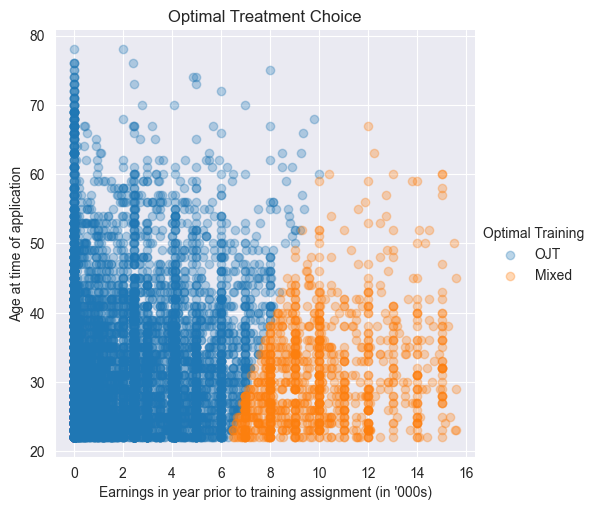

In [82]:
sns.lmplot(x = 'prevearn',
            y = 'age', 
            data = best_training_pred, 
            hue = 'Optimal Training',
            fit_reg=False,
            scatter_kws={'alpha':0.3})
plt.xlabel('Earnings in year prior to training assignment (in \'000s)')
plt.ylabel('Age at time of application')
plt.title('Optimal Treatment Choice')
plt.show()

#### Conclusion

It appears that while the JTPA was indeed effective in improving an applicant's income, the extent of this influence was most pronounced for those who were trained on the job. Given that only 2,645 out of the 6,024 applicants in the treatment arm were assigned to OJT, the aggregate impact of training may have been diluted. An individualized treatment assignment rule displays a clear boundary determining optimal training recommendations - this demonstrates the importance of accounting for an applicant's idiosyncracies when determining the best training regime for them.